# Analyze A/B Test Results 

A/B tests are a useful form of analytics performed by data analysts and data scientists. This is a introductory project so we will be working with simple data, and try to replicate three different scenarios that might be used to determine the viability of the results of an A/B test.

The A/B test data are the result of a 'Randomized Design Test' run by an e-commerce website. Using the three different statistical methods we will showcase the different methods a data analyst can use to analyze the AB test data. The analysis will then help the company determine whether they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

- [Data Preparation](#import)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

> TEMP: [CONTINUE FIXING](#probability)


<a id='import'></a>
### Data Preparation



Import file and libraries and look into basic structure and content of the dataset to identify any approaches to cleanup and tidy up the dataset

In [1]:
# Import
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Good practice to set seed for consistency when debugging
## TIDBIT - Use 42 seed in reference to 'what is the meaning of life'
random.seed(42)

In [3]:
# Read data and show top rows
df = pd.read_csv('./data/320ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# Count the number of records
df.count()[1]

294478

In [5]:
# Number of uniquer users
df.nunique().user_id

290584

In [6]:
# The number of times the `new_page` and `treatment` don't line up.
df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').count()[0]

3893

In [8]:
# Number of null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

#### Assessment Report
* Each record is identified as either a control and treatment group. 'Converted' being a target variable is what we need for analyize AB test results
* Total conversion accounted for is 12%
* Clean-up Assessment: No null values to remove | Possibility of other duplicate and incorrect data

>ACTION: Unique user mismatch - Remove duplicate entries | Consider limited duplication drill down to one day

>ACTION: Remove mismatched data i.e. rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**

#### Clean up


STEP 1: Since we cannot be sure if this row truly received the new or old page, below we create a new dataset **df2** to only keep records where there is no mismatch

In [17]:
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')

In [18]:
# DATA HEALTH: New Count of mismatch | Expect zero
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [19]:
# DATA HEALTH: Running count of old and new dataset | Expect new to be lower
df.count()[1], df2.count()[1]


(294478, 290585)

STEP 2: Next step is to handle the removal of duplicate records. Re-assessing the unique ids results in only one extra record

In [20]:
# HEALTH CHECK: Unique count and total count | If duplicate numbers will be different
df2.count()[1], df2.nunique().user_id

(290585, 290584)

In [21]:
# Identify the one userid that is repeated
df2['user_id'][df2.user_id.duplicated() == True]

2893    773192
Name: user_id, dtype: int64

In [22]:
#Row ID for the repeated user_id
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [23]:
# Drop duplicates | README
df2.drop_duplicates('user_id', inplace = True)

C:\Users\Raja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
# DATA HEALTH: Check if duplicates still exist | Expect zero
df2[df2['user_id'].duplicated() == True]

,user_id,timestamp,group,landing_page,converted


In [25]:
# HEALTH CHECK: REPEAT Unique count and total count | With no dupliates, numbers are the same
df2.count()[1], df2.nunique().user_id

(290584, 290584)

<a id='probability'></a>
### Part I - Probability


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [29]:
(df2.converted == 1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [29]:
ab_control = (df2.query('group == "control"').converted ==1).mean()
ab_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [30]:
ab_treatment = (df2.query('group == "treatment"').converted ==1).mean()
ab_treatment

0.11880806551510564

In [31]:
# create variable to compare with simulated amount
ab_diff = ab_control - ab_treatment

d. What is the probability that an individual received the new page?

In [19]:
(df2.landing_page == 'new_page').mean()

0.50006194422266881

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**
The split for an individual receving a new page is at 50%, which is a fair test. 
From that split, the conversion probabilities for the two groups are almost identical, indicating that the new treatment page has not effect

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

$$H_0: p_{new} - p_{old} \leq 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = df2.query('landing_page == "new_page"').count()[1] 
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = df2.query('landing_page == "old_page"').count()[1] 
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
#Since its 2 values that we need to simulate (1 and 0), we will need to use binomial function
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
observed_diff = new_page_converted.mean() - old_page_converted.mean()
observed_diff

-0.00069745741091135904

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
# Not using bootstrapping as taking differences 10000 times from two randomly generated binomial samples
p_diffs = []
for _ in range(10000):
    new_page_converted_mean = np.random.binomial(1, p_new, n_new).mean()
    old_page_converted_mean = np.random.binomial(1, p_old, n_old).mean()
    p_diffs.append(new_page_converted_mean - old_page_converted_mean)



i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

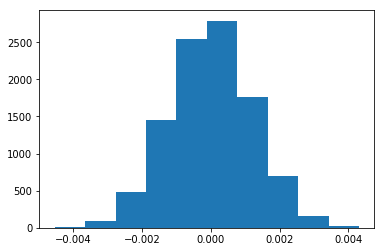

In [27]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

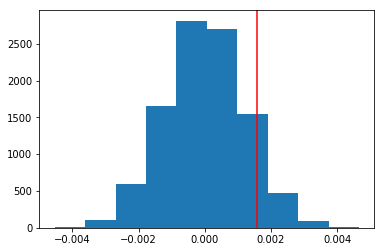

In [32]:
plt.hist(p_diffs)
plt.axvline(ab_diff, c='red');

In [35]:
(p_diffs > ab_diff).mean()

0.093100000000000002

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**ANSWER ** We have essentially calulated the p-value. This value is higher than the Type I error percentage of 5% (or $\alpha$ =  0.05). This represents that we have failed to reject the null hypothesis and confirms that there is not much of a difference between new and old pages 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [56]:

import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[1]
convert_new = df2.query('landing_page == "new_page" and converted == 1').count()[1]
n_old = df2.query('landing_page == "old_page"').count()[1]
n_new = df2.query('landing_page == "new_page"').count()[1]


In [57]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [58]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value

(1.3109241984234394, 0.18988337448195103)

In [59]:
#Find significant of z-score and critical value at 95% confidence
from scipy.stats import norm

norm.cdf(z_score), norm.ppf(1-(0.05/2))

(0.90505831275902449, 1.959963984540054)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**ANSWER: ** The z-score value is lower than the critical value, thus confirming earlier findings of 'failing to reject Null Hypothesis'

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**ANSWER: ** Since the reponse variable is categorical in nature ans is discrete, we have to use Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [7]:
df2['intercept'] = 1

C:\Users\Raja\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']

C:\Users\Raja\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
#Use the Logit model for discrete 
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:56:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**ANSWER** The p-value associate with **ab_page** is 0.190. In regression  p-values are used to indicate if the parameters for the slope is equal to zero in the null hypothesis ($H_{0}$ : $\beta_{1} = 0$ ), and the alternative hypothesis p-value is calculated with a $\neq$ sign. In the Logit regression model a zero p-value indicates statistical significance by indicating the slope of the population to be non-zero, leading to the conclusion of failing to reject the null hypothesis

In Part II, the p-value was set up aoccording to the null hypothesis ($H_0: p_{new} - p_{old} \leq 0$) which is a one-tailed test compared to the two tailed test above due to the $\neq$ sign. The high number confirmed 2 things: value is higher than the Type 1 error, and also simulating a high distribution under the null hypothesis; which also led to failing to reject the null hypothesis

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**ANSWER: ** It is important to consider other metrics as it identifies another factor that might influence the response variable. When running these tests it is always important to consider the best metric, so the more options you have, the better the results will be. 

However, the more factors that are tested, the higher the likelyhood of observing significant differences just by chance. The probability of false positives increases as you increase the number of factors (or metrics) being analyzed at the same time


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [10]:
countries_df = pd.read_csv('./000 data/202countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [44]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [60]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [73]:
# will use 'CA' as baseline
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept','UK', 'US']])

In [74]:
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:               1.521e-05
Time:                        13:38:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [75]:
np.exp(results.params)

intercept    0.130350
UK           1.052027
US           1.041647
dtype: float64

**ANSWER** : The high p values indicate that the values on the countries are not statistically significant. It can also be seen that all the countries (UK, CA, US) are equal in their non effect on conversion rates as seen by the results above being approximately equal to 1

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [76]:
### Fit Your Linear Model And Obtain the Results
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])

In [77]:
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 20 Feb 2018   Pseudo R-squ.:               2.323e-05
Time:                        13:42:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [78]:
np.exp(results.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

<a id='conclusions'></a>
## Conclusions

Due to the values for the exponentials all being 1, we can conclude that the page, individual countries (UK, US, CA) are approximately 1 times as likely to have have an effect of converting, which is essentially saying that they do not have have an effect on conversion rates. 


### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.